### Imports

In [1]:
%pip install PyMySQL
%pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 kB 3.8 MB/s eta 0:00:00


In [12]:
%pip uninstall fynesse -y
%pip install git+https://github.com/Joseph-Rance/ADS.git

Found existing installation: fynesse 0.1.0
Uninstalling fynesse-0.1.0:
  Successfully uninstalled fynesse-0.1.0
  Cloning https://github.com/Joseph-Rance/ADS.git to /tmp/pip-req-build-z52pw1ot
  Running command git clone --filter=blob:none --quiet https://github.com/Joseph-Rance/ADS.git /tmp/pip-req-build-z52pw1ot
  Resolved https://github.com/Joseph-Rance/ADS.git to commit 12659089a09f5317ab49428505073bcdff5413d1
  Preparing metadata (setup.py) ... done
  Created wheel for fynesse: filename=fynesse-0.1.0-py3-none-any.whl size=12821 sha256=71cf8538bc17b676fe5c5ccd7d61a014e33d59100ec2b276a0fcec700f1b9fbd
  Stored in directory: /tmp/pip-ephem-wheel-cache-vyx57l2j/wheels/21/18/c1/e8c583da8bbadd83bc03cf253c666b89c70997a16eb5e3f5e8
Successfully built fynesse


In [1]:
from random import shuffle, seed
from geopy import distance
from tqdm import tqdm
from ipywidgets import IntProgress, HBox, Label
from IPython.display import display
import matplotlib.pyplot as plt
import osmnx as ox

import fynesse

In [2]:
seed(0)

In [3]:
import seaborn as sns
sns.set_theme()

### Question 1

#### Access price and poscode data

Question 1 asks us to download two datasets and put them in our AWS database. The code for this can be found in the [`fynesse/access`](https://github.com/Joseph-Rance/ADS/tree/main/fynesse/access) folder of my git repo. In `sql_server/SQLConnection` is a class that retrieves the database credentials, sets up the connection, and does some additional housekeeping. An object can then be used to get the connection without needing to manually ping it to keep it alive.

I added a static method to make it easy to keep track of a single connection instance via the singleton design pattern. I also created a decorator, `connect`, that passes the singleton connection directly to the function (for example, [`sql_server/query_table`](https://github.com/Joseph-Rance/ADS/blob/8a760fe8512f51a6ff28154ba49ce7c5aac7f8ec/fynesse/access/sql_server.py#L62) does not require a connection input due to the decorator).

The credentials for accessing the database are included in the GitHub. I know this isn't great, but I figure the worst someone can do is drop the tables, which I can just regenerate.

The remaining code for populating and querying these two databases is relatively straightforward, using the requests library to download the files from the links provided.

I also created a combined database using the `dask` (as `dd`) library:
```python
table_0 = dd.read_csv("temp_data_0/open_postcode_geo.csv", header=None,
                        names=COLUMNS_0, dtype={a: str for a in COLUMNS_0}) \
                        [COLUMNS_0[:-1]]  # this is to force db_id from dataset 1

table_1 = dd.read_csv("temp_data_1.csv", header=None,
                        names=COLUMNS_1, dtype={a: str for a in COLUMNS_1})

table_2 = dd.merge(table_0, table_1, on='postcode', how='inner')[COLUMNS_2]

table_2.to_csv("temp_data_2.csv", single_file=True)
```
I used the schema below:
```SQL
CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `latitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1;
```


The code to create the tables (including the joined table) is below (not in code blocks so I don't accidentally run it):
```python
print("creating pp dataset")
fynesse.access.prices_dataset.create_table()
fynesse.access.prices_dataset.load_data()
fynesse.access.sql_server.update_table("CREATE INDEX postcode_p ON pp_data (postcode);")
print("getting pp row count (target: ~28,258,161)")
fynesse.access.sql_server.query_table("SELECT COUNT(*) FROM `pp_data`")
```
```
creating pp dataset
100%|██████████| 29/29 [15:08<00:00, 31.34s/it]
getting pp row count (target: ~28,258,161)
((28634236,),)
```
```python
print("creating postcodes dataset")
fynesse.access.postcodes_dataset.create_table()
fynesse.access.postcodes_dataset.load_data()
fynesse.access.sql_server.update_table("CREATE INDEX postcode_l ON postcode_data (postcode);")
print("getting postcodes row count (target: 2,631,536)")
fynesse.access.sql_server.query_table("SELECT COUNT(*) FROM `postcode_data`")
```

```
creating postcodes dataset
getting postcodes row count (target: 2,631,536)
((2631536,),)
```
```python
print("creating combined dataset")
fynesse.access.combined_dataset.create_table()
fynesse.access.combined_dataset.load_data()
```
```
creating combined dataset
```
There is a slight discrepancy between the target number of records and the true number for the top code block which I assume is due to new records being added.

Below is a description of what the schema for the first table does.

Drop table deletes the table if it already exists so we don't get conflicting definitions. Create table then defines the name of each column in the table (for example `db_id`), its type (e.g. `bigint(20)`), and sone attributes about it (e.g. if it is unsigned, and whether it can be null). Then, the schema ends with:

```
DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```

which sets the encoding to utf8, and uses the utf8_bin option for collation, which is useful for sorting. Auto increment allows a unique number to be allocated to each record in the database.

I have added the relevant source attribution to the code where the data is downloaded.

### Question 2

#### Access + assess OSM data

> Note on git repo: in the above section, I explained a little bit how I structured the code in the git repo. In the below sections, each function that is called from the fynesse library is somewhat self contained, so I have been slightly more sparse on the details. The functionality should be fairly self explanatory based on function names. I have also included a small number of tests in the repository to ensure the code works as intended

By common sense, the main benefit that the OSM data can provide is distance metrics to different things someone would like to live near to and far away from. There is a list of tags for map features [online](https://wiki.openstreetmap.org/wiki/Map_features), from which I have compiled the below list of features I think are relevant:
```
amenity=fast_food           amenity=restaurant
amenity=school              amenity=college
amenity=library             amenity=parking
amenity=bank                amenity=hospital
amenity=nightclub           building=office
shop=supermarket            building=religious
leisure=park                leisure=playground
building=sports_hall        railway=station
tourism=museum              shop
```
I also think that while the distance to the closest facility is relevant, so might be the distance to the second closest. If you live in a small village with one shop next door that isn't the same as being on the high street in a city surrounded by many shops.

I have created scatter plots with fitted OLS models of price against each of these features. I could have instead constructed a covariance matrix, but I think the graphs give a better feel for the data. For example, they make it clearer when correlation might only be predicted due to noise in the data.

I think it would make sense to apply a log to the distance value, because if a facility is 100m further away that means a lot more if it is only 50m away compared to if it was 1km away, and this is the kind of property that is characterised by a log function.

In [ ]:
data_pois = fynesse.access.sql_server.query_table("SELECT price, latitude, longitude FROM `prices_coordinates_data` LIMIT 500;")
shuffle(data_pois)
data_pois = data_pois[:200]

In [ ]:
tags = {"amenity": ["fast_food", "restaurant", "school", "college", "library", "parking", "bank", "hospital", "nightclub"], "shop": "supermarket",  # we have shop twice so we can search for general shops or specifically supermarkets
        "building": ["office", "religious", "sports_hall"], "leisure": ["park", "playground"], "railway": "station", "tourism": "museum"}

tag_names = [i for a,b in tags.items() for i in ([a] if b == True else [a+"="+b] if type(b) == str else [a+"="+i for i in b])]
print(f"tag_names: {tag_names}")

poi_data = []

for p in tqdm(data_pois):
    distances = fynesse.access.osm.get_closest_pois(p, tags, tag_names)
    poi_data.append((p[0], distances))

In [ ]:
fig, axs = plt.subplots(9, 4, sharex=True, sharey=True, figsize=(20, 40))

for i in range(34):
    fynesse.assess.plot_poi_data(poi_data, i, tag_names, ax=axs[i//4][i%4])

plt.tight_layout()
plt.show()

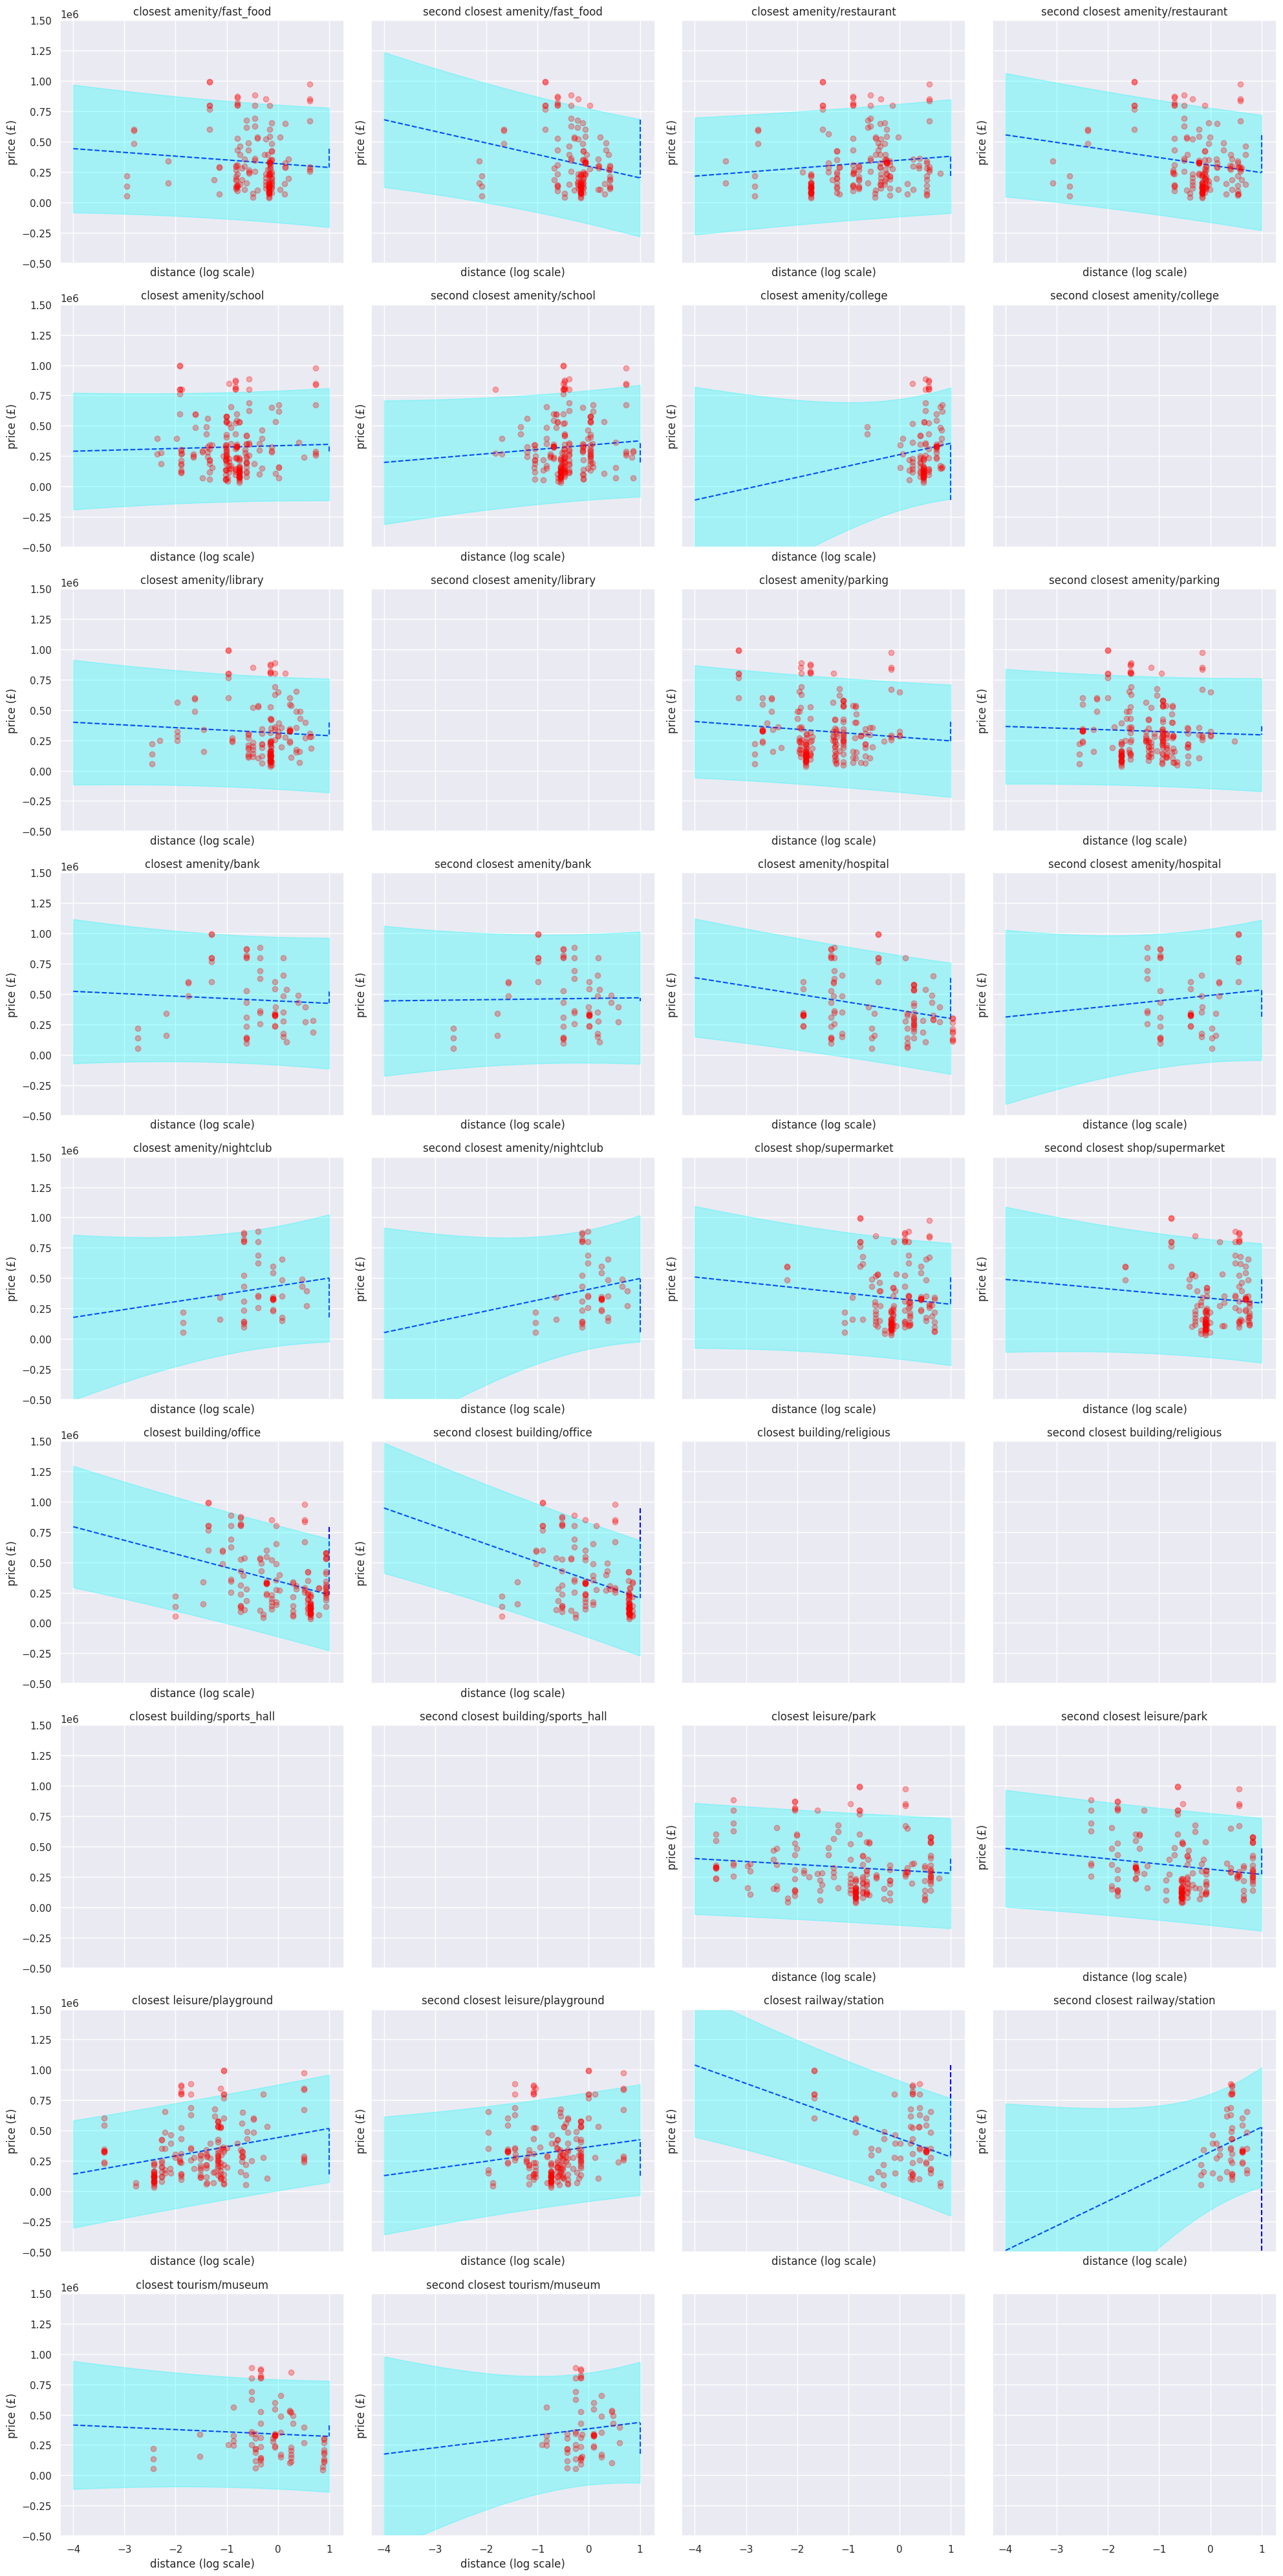

There are certainly some weird patterns in this data (and a lack of data for some cells, for example the second closest library). There are also quite a few empty cells (where there were no near facilities for any of the properties). However, I think this data makes general sense (keeping in mind that there is a small enough sample size to make noise a big factor). Below I have listed the instances with the clearest correlations (all just the closest not second closest):
 - nightclub: more expensive to live further away - I live next to a nightclub so I certainly know that this is very reasonable.
 - office: more expensive to live closer - as you would expect.
 - railway station: more expensive to live closer - this makes sense because (1) that is something useful to live close to and (2) people who get the train to work would presumably earn more in general as they are travelling to an area with bettern job(s).
 - college*: more expensive to live close - I can come up with reasons why this might be the case (e.g. confounded variables), but this is less clear

\* There isn't a clear correlation in the above image, however this list is based on my observations after rerunning the above graphs multiple times.

It could be a good idea to use these models above in our final prediction, but for the sake of simplicity, I will just pass the distance metrics for the features listed in the bullet points here to the model

### Question 3

#### Assess price and postcode data

The tables I have above have the below columns:

```
postcodes.postcode                          - not useful for our model if we have lat, lon
postcodes.status                            - not important
postcodes.usertype                          - unclear what this means (even from the website). Going to assume it isn't useful
postcodes.easting                           - same as postcode
postcodes.northing                          - same as postcode
postcodes.positional_quality_indicator      - positional quality does not matter for our level or accuracy
postcodes.country                           + this might be an interesting consideration ontop of lat, lon
postcodes.latitude                          + useful
postcodes.longitude                         + useful
postcodes.postcode_no_space                 - same as postcode
postcodes.postcode_fixed_width_seven        - same as postcode
postcodes.postcode_fixed_width_eight        - same as postcode
postcodes.postcode_area                     - same as postcode
postcodes.postcode_district                 - same as postcode
postcodes.postcode_sector                   - same as postcode
postcodes.outcode                           - same as postcode
postcodes.incode                            - same as postcode
postcodes.db_id                             - same as postcode
prices.transaction_unique_identifier        - same as postcode
prices.price                                + necessary for training
prices.date_of_transfer                     + useful
prices.postcode                             - repeated from postcodes.postcode
prices.property_type                        + useful
prices.new_build_flag                       - not useful because we don't know if we are predicting for a new build or not
prices.tenure_type                          + useful
prices.primary_addressable_object_name      - not sure what this is but it doesn't sound super important
prices.secondary_addressable_object_name    - not sure what this is but it doesn't sound super important
prices.street                               - same as postcode
prices.locality                             - same as postcode
prices.town_city                            - same as postcode
prices.district                             - same as postcode
prices.county                               - same as postcode
prices.ppd_category_type                    + Seems important. Anything for class B will likely be differently priced
prices.record_status                        - not important
prices.db_id                                - not useful for prediction
```
[link to prices descriptions](https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd), [link to postcodes descriptions](https://www.getthedata.com/open-postcode-geo)

Almost every field is `NOT NULL` so that means we don't have to clean up anything in that regard.

I want to invesitage each column marked with a `+` in turn. I will do each independently, which is possibly naive, but I would otherwise have to look at 28 different combinations for even just considering how pairs of attributes affect eachother.

First, `postcodes.country`. We only have records of "all residential property sales in England and Wales", which means the country field would only be indicating if the property is in Wales. I doubt that a flag for a house being in Wales will contribute much more to the model than a latitude value and I didn't include it in my joined data so I won't include this in my model.

The next two fields are `postcodes.latitude` and `postcodes.longitude`. First I want to see a plot of prices on the macro scale.

In [ ]:
data_uk = fynesse.access.sql_server.query_table("SELECT price, latitude, longitude FROM `prices_coordinates_data` WHERE price <= 500000 LIMIT 5000;")
shuffle(data_uk)
data_uk = data_uk[:1000]

In [ ]:
bounds = {
    "north": 58.177,
    "south": 49.772,
    "east":   2.949,
    "west": - 9.814
}
plt.figure(figsize=(50, 46))

# unfortunately the osm outline for uk includes maritime borders
# so I will have to go with this low res version
fynesse.assess.plot_country("United Kingdom")
fynesse.assess.scatter_prices_lat_lon(data_uk, bounds)

plt.tight_layout()
plt.show()

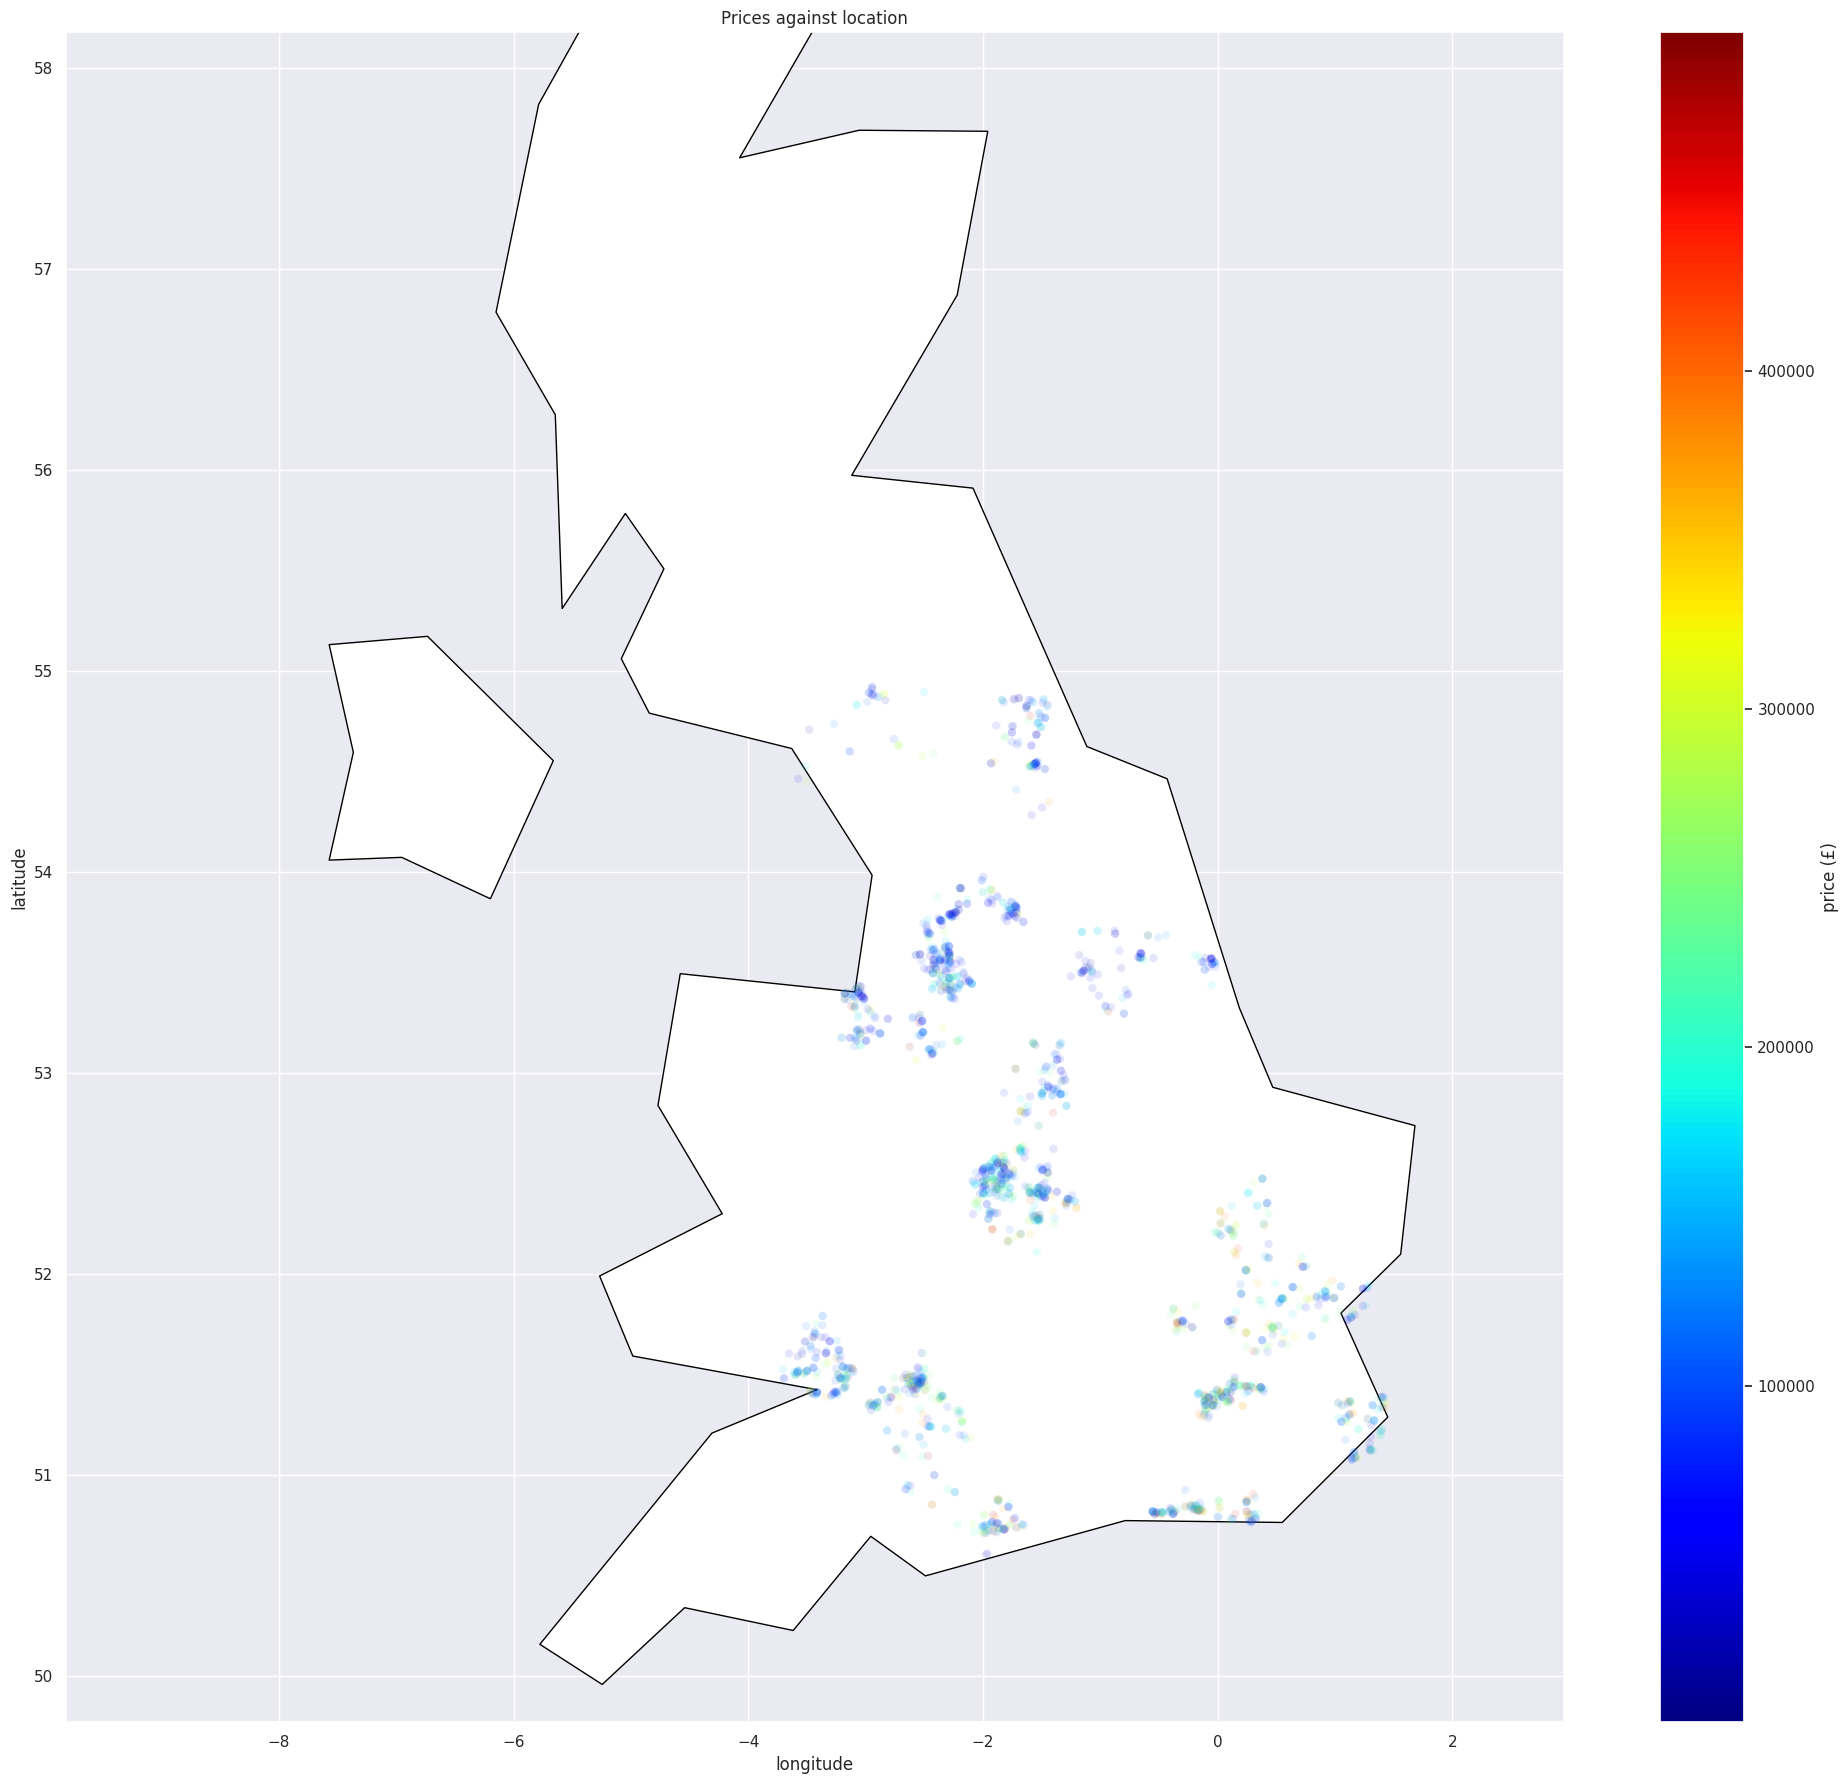

More and less expensive houses seem pretty mixed here (perhaps south is *slightly* more expensive than north). It might be true that in the presence of other data, location on this scale does make a difference (i.e. a house in Cornwall might be cheaper than a similar house in the middle of London), but there is a lot of complexity for the linear model to capture so I think giving the model latitude and longitude values isn't going to be super useful.

Although pure latitude and logitude might not be super useful, by considering the prices of houses in the same area, we can get an idea if we are situated in a cheap or expensive neighbourhood. Reading ahead, we will be expected to train a linear model on houses in the general area of a given coordinate, so I would like to assess the size that box should be.

Below is a set of data sampled from in Cambridge. Of course Cambridge will not be the same as every city in the UK, but it will give us a general idea of how distance affects how relevant house prices are.

In [4]:
# join necessary because I (stupidly) didn't include city name in the joined dataset
data_cam = fynesse.access.sql_server.query_table("SELECT p.price, l.latitude, l.longitude, p.date_of_transfer \
                                                  FROM ( \
                                                            SELECT * \
                                                            FROM `pp_data` \
                                                            WHERE town_city = 'CAMBRIDGE' \
                                                              AND price < 200000 \
                                                            LIMIT 5000 \
                                                        ) as p \
                                                  INNER JOIN ( \
                                                            SELECT * \
                                                            FROM `postcode_data` \
                                                            WHERE postcode_area = 'CB' \
                                                            LIMIT 2500 \
                                                        ) as l \
                                                  ON p.postcode = l.postcode;")

In [5]:
sns.reset_orig()  # theme makes the map look weird

In [ ]:
bounds = {
    "north": 52.210,
    "south": 52.175,
    "east":   0.185,
    "west":   0.120
}

fig, ax = plt.subplots()
fynesse.assess.plot_roads(bounds, ax=ax)
fynesse.assess.scatter_prices_lat_lon(data_cam, bounds, alpha=0.35, ax=ax)

plt.tight_layout()
plt.show()

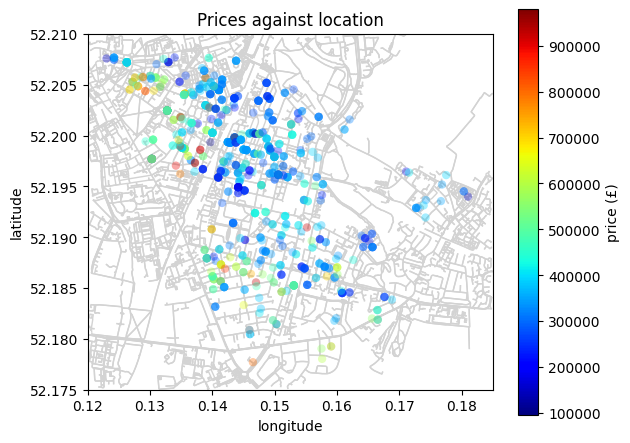

In [11]:
sns.set_theme()

There do seem to be general clusters of yellow points and blue points in this image

We can construct two matrices (one for the difference in price between each pair of properties and one for the distance between each pair of properties), and then plot the price matrix against the distance matrix.

In [5]:
data_cam = fynesse.access.sql_server.query_table("SELECT p.price, l.latitude, l.longitude, p.date_of_transfer \
                                              FROM ( \
                                                       SELECT * \
                                                       FROM `pp_data` \
                                                       WHERE town_city = 'CAMBRIDGE' \
                                                       LIMIT 2500 \
                                                   ) as p \
                                               INNER JOIN ( \
                                                       SELECT * \
                                                       FROM `postcode_data` \
                                                       WHERE postcode_area = 'CB' \
                                                       LIMIT 2500 \
                                                   ) as l \
                                               ON p.postcode = l.postcode;")

In [ ]:
prices = fynesse.assess.get_matrix(data_cam, lambda h0, h1 : abs(h0[0] - h1[0]))
distances = fynesse.assess.get_matrix(data_cam, lambda h0, h1 : distance.distance((float(h0[1]), float(h0[2])), (float(h1[1]), float(h1[2]))).km)

fig, axs = plt.subplots(1, 2, sharey=True)

axs[0].imshow(prices[:100, :100])
axs[1].imshow(distances[:100, :100])

plt.tight_layout()
plt.show()

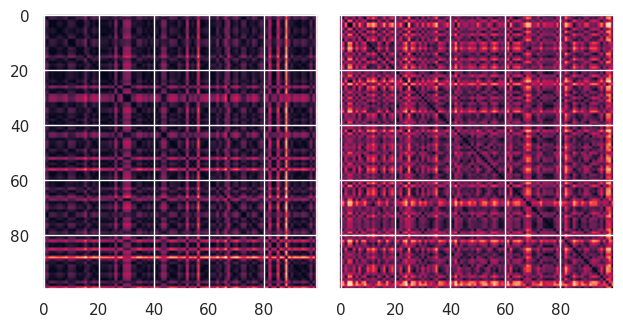

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

fynesse.assess.plot_prices_distances(prices, distances, 4.5, ax=axs[0])
fynesse.assess.plot_prices_distances(prices, distances, 1.0, ax=axs[1])

max_distance = [4.5, 1.0]
for i in range(2):
    axs[i].set_title(f"difference in house price within {max_distance[i]}km")
    axs[i].set_xlabel("distance (km)")
    axs[i].set_ylabel("price difference (£)")

plt.tight_layout()
plt.show()

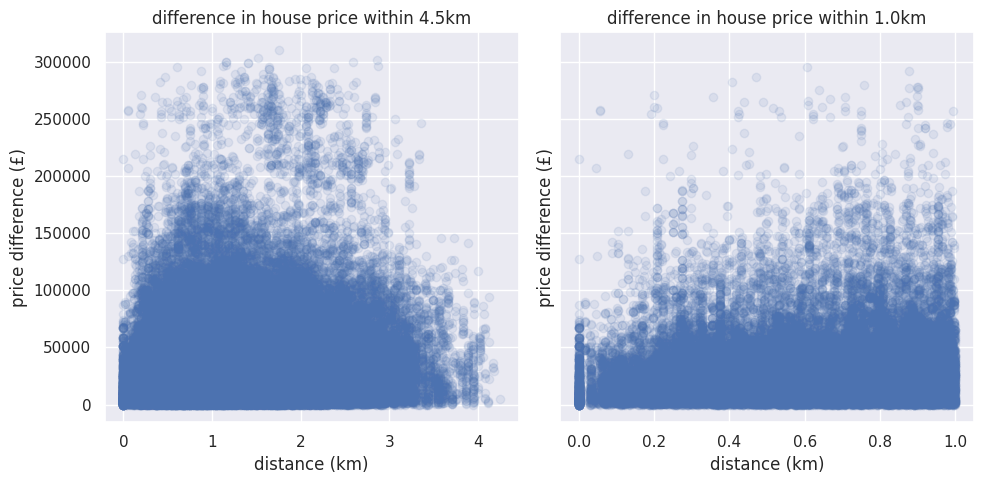

In general, we can see that on the right graph, as we get further away, the variance in house price increases (i.e. houses in one specific area have a tighter price distribution than houses further away that can be from a variety of neighbourhoods). This is very dependent on other factors such as the city, but I think 0.75km would be a fair radius to consider houses to be in the "same area" from. I could also add some kind of weighting so that houses witin 200m are added to the dataset twice, but I think this is overcomplicating things.

The next attribute is `prices.date_of_transfer`, which should be quite straightforward

In [ ]:
data_date = []
for i in range(1995, 2023):
    data_date += fynesse.access.sql_server.query_table(f"SELECT price, date_of_transfer FROM `pp_data` WHERE date_of_transfer > '{i}/1/1' AND price < 700000 LIMIT 100;")

fynesse.assess.scatter_prices_date(data_date)
fynesse.assess.model_prices_date(data_date)

plt.tight_layout()
plt.show()

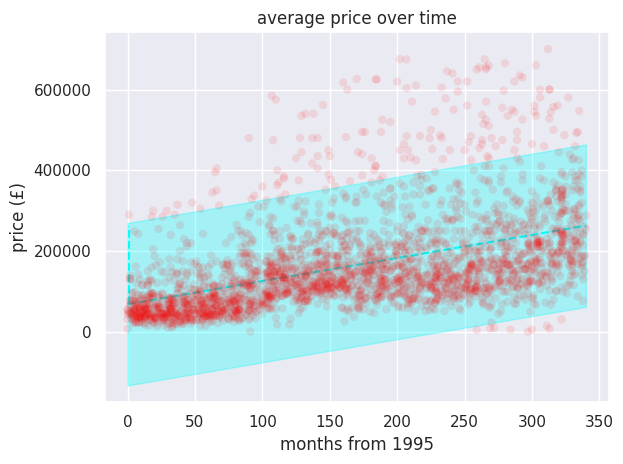

We can clearly that the prices increase at basically a linear rate. While this is a little depressing, it *does* make the model a bit simpler.

We can skip `prices.property_type` as it is obviously relevant

For `prices.tenure_type`, I want to look at how the different options are distributed.

In [ ]:
data_tenure_type = fynesse.access.sql_server.query_table(f"SELECT price, tenure_type FROM `pp_data` LIMIT 1000;")

In [ ]:
fs, ls = [i[1] for i in data_tenure_type].count("F"), [i[1] for i in data_tenure_type].count("L")
bar = HBox([Label(f"{fs} freeholds"), IntProgress(min=0, max=fs+ls), Label(f"{ls} leaseholds")])
display(bar)
bar.children[1].value = fs
f_prices, l_prices = [i[0] for i in data_tenure_type if i[1] == "F"], [i[0] for i in data_tenure_type if i[1] == "L"]
print(f"average price of a freehold:  £{sum(f_prices) / len(f_prices):,.2f}\naverage price of a leasehold: £{sum(l_prices) / len(l_prices):,.2f}")

average price of a freehold:  £74,975.92
average price of a leasehold: £60,078.94


If we are trying to predict the price of a freehold house, we should probably ignore all records with `tenure_type` as `L`.

Finally, we can do similar anaylsis for `prices.ppd_category_type`

In [ ]:
data_ppd_category_type = fynesse.access.sql_server.query_table(f"SELECT price, ppd_category_type FROM `pp_data` LIMIT 10000;")

In [ ]:
a, b = [i[1] for i in data_ppd_category_type].count("A"), [i[1] for i in data_ppd_category_type].count("B")
bar = HBox([Label(f"{a} standard price paid (A)"), IntProgress(min=0, max=a+b), Label(f"{b} additional price paid (B)")])
display(bar)
bar.children[1].value = a
a_prices, b_prices = [i[0] for i in data_ppd_category_type if i[1] == "A"], [i[0] for i in data_ppd_category_type if i[1] == "B"]
print(f"average standard price (A): £{sum(a_prices) / len(a_prices):,.2f}\nadditional price paid (B):  £{sum(b_prices) / len(b_prices):,.2f}")

average standard price (A): £68,478.89
additional price paid (B):  £253,000.00


Similar to `tenure_type`, we should probably ignore records with `B` for `ppd_category_type`.

I will not consider any metrics not provided as columns in the table. For example, you might be able to use the number of properties sold nearby at around the same time to make predictions.

Summary: the joined table should ignore some records based on `ppd_category_type` and `tenure_type`, the most relevant properties are within 750m of the property we are considering (we might consider weighting these properties), and price increases roughly linearly over time.

#### Address problem

In the above sections, I have asserted that the below features would be useful to pass to the model:
 - log distance to closest nightclub
 - log distance to closest railway station
 - log distance to closest office
 - log distance to closest college
 - date of sale
 - property type (OHE)

The model will be trained on data within 750m of the target property. and trains an OLS linear model to predict the price our our house. The OLS model seems like a good default, when the distribution seems to be generally normal.

In [ ]:
fynesse.address.predict_price(51.3808543, -0.2545877, "2022-01-01 00:00", "D")

Selecting one of the houses from the tick (101 The Manor Drive, Worcester Park, May 2022), I get a value of £780,329.90, which seems reasonable. Nearby houses seem to have sold at a similar time for prices such as [£735,000.00](https://www.rightmove.co.uk/house-prices/details/england-101838782-12360169?s=b5f3e80bf4b3a82467c93805d92c6bc6837d0cd2956e1b706ce3e7f351a7fb0f#/).

I haven't been able to perform much quantitative evaluation on how this model performs because prediction takes a long time so predicting more than 5 houses is going to take a long time. However, I have found the predictions to be generally reasonable based on my own assumptions of house prices and the true values recorded in the dataset.

I had added a prediction accuracy warning for low $R^2$ value (although the $R^2$ values tend to be very high), as well as if we can't locate many houses nearby, as these seem like the main factors that could make our predictions very noisy

There are some major limitations of this model. For example, the database is sorted since I added the data in year by year. This makes it likely that we will consider more houses from the 1990s than from the 2020s, for example. However, the small area we are searching in means that in practice I have observed that we do still get some houses from later on. Another limitation is that I am giving the model a very small amount of data. The model doesn't, for example, know how big the house is (other than guessing via its type), which would arguably be one of the biggest factors that determine house price.

Statsmodels also returns the trained parameters. I have found that in general the largest magnitude parameters are type and date (with property type being a fair amount more than anything else). This makes sense to me as that is what I would place the most emphasis on if manually trying to guess house prices. If I had more time to analyse the model's performance, I would like to generate some heatmaps of where prices would be predicted to be higher within a city, as I think that would be really interesting, but unfortunately that would take a lot of calls to the `predict_price` function which takes a long time.

### LLMs

I did not use any LLMs to write code for the assignment. I generally struggle to let an LLM write parts of my codebase, because it makes the style feel a bit inconsistent (and writing the code myself isn't going to take so long). However, I did use LLMs to explain concepts. For example, the difference between freehold and leasehold.